In [111]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# uncomment to load
with gzip.open('data/poetry_umbrella_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [87]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned'],
      dtype='object')

In [88]:
df.genre.value_counts(normalize=True)

modern          0.292276
metropolitan    0.249543
pre_1900        0.237888
avant_garde     0.220293
Name: genre, dtype: float64

In [89]:
# assign a features dataframe
X = df[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'end_rhyme', 'avg_syllables_word', 'string_titled', 'string_cleaned']]
# assign a target variable
y = df['genre']

In [93]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3282, 9) (3282,)
(1094, 9) (1094,)


In [94]:
# define vocab
vocab = Counter()
# add all docs to vocab
for poem in X_train.string_cleaned:
    words = poem.split()
    vocab.update(word for word in words)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

28355
[('love', 2218), ('say', 1819), ('day', 1699), ('make', 1656), ('see', 1648), ('eye', 1539), ('know', 1460), ('night', 1434), ('life', 1424), ('man', 1379), ('time', 1333), ('light', 1314), ('old', 1284), ('heart', 1233), ('thing', 1118), ('hand', 1084), ('look', 1072), ('long', 1040), ('still', 1012), ('world', 976), ('take', 973), ('never', 958), ('white', 956), ('sea', 935), ('face', 930), ('let', 917), ('wind', 895), ('sun', 874), ('little', 854), ('even', 846), ('god', 839), ('back', 833), ('men', 827), ('give', 823), ('dream', 823), ('year', 821), ('way', 809), ('thought', 805), ('tree', 793), ('death', 793), ('soul', 785), ('well', 782), ('turn', 767), ('earth', 762), ('away', 758), ('water', 748), ('die', 748), ('head', 743), ('dead', 732), ('air', 730)]


In [95]:
# keep tokens with a min occurrence
min_occurence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurence]
print(len(tokens))

15397


In [96]:
# # uncomment to save
# with gzip.open('data/tokens.pkl', 'wb') as goodbye:
#     pickle.dump(tokens, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/tokens.pkl', 'rb') as hello:
#     tokens = pickle.load(hello)

In [97]:
def clean_string_cleaner(text, vocab):
    words = text.split()
    words = [word for word in words if word in vocab]
    clean_text = ' '.join(words)
    return clean_text

In [98]:
X_train['vocab_string'] = X_train.string_cleaned.apply(lambda x: clean_string_cleaner(x, tokens))
X_test['vocab_string'] = X_test.string_cleaned.apply(lambda x: clean_string_cleaner(x, tokens))

In [99]:
from keras.preprocessing.text import Tokenizer

train_docs = X_train.vocab_string
test_docs = X_test.vocab_string

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

In [100]:
# sequence encode
encoded_train_docs = tokenizer.texts_to_sequences(train_docs)

In [101]:


# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_train_docs, maxlen=max_length, padding='post')

In [102]:
# sequence encode
encoded_test_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')

In [103]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

In [80]:


# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
# # CUSTOM ADD
model.add(Dropout(0.2))
# # CUSTOM KERNEL
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
# # CUSTOM ADD
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3861, 50)          724800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 3861, 50)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3859, 32)          4832      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1929, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61728)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                617290    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
__________

In [104]:
# instantiate the encoder
le = LabelEncoder()

# fit and transform the target train set
ytrain = le.fit_transform(y_train)

# transfomr the target test set
ytest = le.transform(y_test)

In [83]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest),
                    verbose=2)

Train on 2931 samples, validate on 1445 samples
Epoch 1/10
 - 11s - loss: 1.3812 - acc: 0.2989 - val_loss: 1.3704 - val_acc: 0.3426
Epoch 2/10
 - 11s - loss: 1.3515 - acc: 0.3323 - val_loss: 1.3493 - val_acc: 0.3536
Epoch 3/10
 - 11s - loss: 1.2842 - acc: 0.3896 - val_loss: 1.3347 - val_acc: 0.3578
Epoch 4/10
 - 11s - loss: 1.1951 - acc: 0.4313 - val_loss: 1.3650 - val_acc: 0.3419
Epoch 5/10
 - 11s - loss: 1.1408 - acc: 0.4446 - val_loss: 1.4127 - val_acc: 0.3654
Epoch 6/10
 - 11s - loss: 1.1082 - acc: 0.4565 - val_loss: 1.4824 - val_acc: 0.3529
Epoch 7/10
 - 11s - loss: 1.0643 - acc: 0.4691 - val_loss: 1.5949 - val_acc: 0.3661
Epoch 8/10
 - 11s - loss: 1.0575 - acc: 0.4763 - val_loss: 1.5809 - val_acc: 0.3543
Epoch 9/10
 - 12s - loss: 1.0457 - acc: 0.4916 - val_loss: 1.7831 - val_acc: 0.3626
Epoch 10/10
 - 13s - loss: 1.0261 - acc: 0.5145 - val_loss: 1.7985 - val_acc: 0.3737


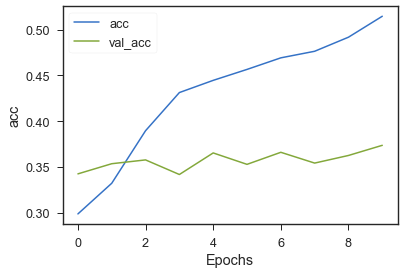

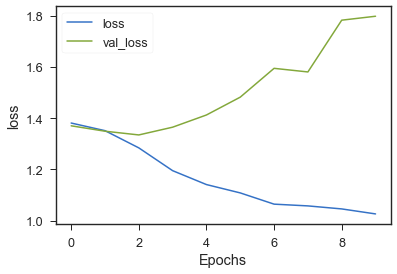

In [84]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
max_features = 1000
maxlen = 201
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [109]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
# # CUSTOM ADD
model.add(Dropout(0.25))
# # CUSTOM KERNEL
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
# # CUSTOM ADD
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 3868, 100)         1539800   
_________________________________________________________________
dropout_9 (Dropout)          (None, 3868, 100)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3864, 128)         64128     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1932, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 247296)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2472970   
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
__________

In [112]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='data/best_model.h5', monitor='val_loss', save_best_only=True)]

In [114]:
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs = 10
history = model.fit(Xtrain, ytrain, epochs=num_epochs, validation_data=(Xtest, ytest), callbacks=callbacks,
                    verbose=2)

Train on 3282 samples, validate on 1094 samples
Epoch 1/10
 - 65s - loss: 1.4000 - acc: 0.3221 - val_loss: 1.3504 - val_acc: 0.3803
Epoch 2/10
 - 84s - loss: 1.2755 - acc: 0.3818 - val_loss: 1.2180 - val_acc: 0.4570
Epoch 3/10
 - 82s - loss: 1.0894 - acc: 0.4805 - val_loss: 1.1563 - val_acc: 0.4799
Epoch 4/10
 - 84s - loss: 0.9192 - acc: 0.5551 - val_loss: 1.1758 - val_acc: 0.5101
Epoch 5/10
 - 86s - loss: 0.7930 - acc: 0.5945 - val_loss: 1.2566 - val_acc: 0.4835


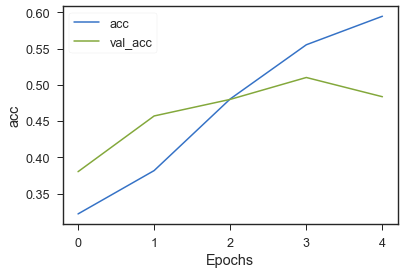

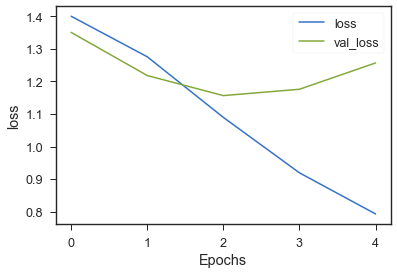

In [115]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [76]:
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 47.404844


In [15]:
vocab['love']

39384

In [13]:
vocab[-50:]

TypeError: unhashable type: 'slice'

In [9]:
X.string_cleaned[0].split()

['california',
 'institute',
 'technology',
 'care',
 'god',
 'damn',
 'smart',
 'guy',
 'bore',
 'rain',
 'hell',
 'day',
 'long',
 'nothing']

## Baseline model -- just vectors

In [7]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec = vectorizer.transform(X_test.string_cleaned)

In [8]:
# instantiate the naive bayes classifier
bnb_baseline_vec = BernoulliNB()

# fit it to our training set
bnb_baseline_vec.fit(X_train_vec, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [9]:
# predict the new document from the testing dataset
y_train_preds_vec = bnb_baseline_vec.predict(X_train_vec)
y_test_preds_vec = bnb_baseline_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
bnb_baseline_vec_acc_train = accuracy_score(y_train, y_train_preds_vec)
bnb_baseline_vec_f1_train = f1_score(y_train, y_train_preds_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_vec_acc_train}')
print(f'F1 score: {bnb_baseline_vec_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_vec_acc_test = accuracy_score(y_test, y_test_preds_vec)
bnb_baseline_vec_f1_test = f1_score(y_test, y_test_preds_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_vec_acc_test}')
print(f'F1 score: {bnb_baseline_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_vec))

-----TRAIN-----
Accuracy: 0.6066422912858014
F1 score: 0.6087765944613979

-----TEST-----
Accuracy: 0.4670932358318099
F1 score: 0.4253300995343577

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.61      0.08      0.15       241
 avant_garde       0.66      0.34      0.45       273
      modern       0.37      0.92      0.53       320
    pre_1900       0.77      0.41      0.53       260

    accuracy                           0.47      1094
   macro avg       0.60      0.44      0.41      1094
weighted avg       0.59      0.47      0.43      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 20  33 179   9]
 [ 12  92 160   9]
 [  1  12 293  14]
 [  0   3 151 106]]


#### Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
## Baseline model -- vectors + numerical data

#### Dataframe creation

In [10]:
# turn our tf-idf vectors into a dataframe so we can attach numerical data
X_train_vec_df = pd.DataFrame.sparse.from_spmatrix(X_train_vec, columns=vectorizer.get_feature_names())
X_test_vec_df = pd.DataFrame.sparse.from_spmatrix(X_test_vec, columns=vectorizer.get_feature_names())

In [11]:
# separate out our numerical data
X_train_nums = X_train.drop(columns=['string_titled', 'string_cleaned'])
X_test_nums = X_test.drop(columns=['string_titled', 'string_cleaned'])

#### Scale and combine

In [12]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [13]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec_df], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec_df], axis=1)

#### Model

In [14]:
# instantiate the naive bayes classifier
bnb_baseline_combo = BernoulliNB()

# fit it to our training set
bnb_baseline_combo.fit(X_train_combo, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [15]:
# predict the new document from the testing dataset
y_train_preds_combo = bnb_baseline_combo.predict(X_train_combo)
y_test_preds_combo = bnb_baseline_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
bnb_baseline_combo_acc_train = accuracy_score(y_train, y_train_preds_combo)
bnb_baseline_combo_f1_train = f1_score(y_train, y_train_preds_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_combo_acc_train}')
print(f'F1 score: {bnb_baseline_combo_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_combo_acc_test = accuracy_score(y_test, y_test_preds_combo)
bnb_baseline_combo_f1_test = f1_score(y_test, y_test_preds_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_combo_acc_test}')
print(f'F1 score: {bnb_baseline_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_combo))

-----TRAIN-----
Accuracy: 0.6130408287629494
F1 score: 0.6156874992871177

-----TEST-----
Accuracy: 0.4680073126142596
F1 score: 0.4299390646948131

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.60      0.10      0.17       241
 avant_garde       0.65      0.34      0.44       273
      modern       0.37      0.91      0.53       320
    pre_1900       0.77      0.41      0.53       260

    accuracy                           0.47      1094
   macro avg       0.60      0.44      0.42      1094
weighted avg       0.59      0.47      0.43      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 24  35 175   7]
 [ 14  92 158   9]
 [  2  12 290  16]
 [  0   3 151 106]]


#### A modest bump. A closer look at the confusion matrices do reveal a better spread across true positives

## Decision Tree -- vectors

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [17]:
# instantiate the naive bayes classifier
tree_vec = DecisionTreeClassifier()

# fit it to our training set and evaluate
cross_val_score(tree_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.4224924 , 0.38601824, 0.40853659, 0.39329268, 0.38719512,
       0.39939024, 0.41158537, 0.42073171, 0.41158537, 0.42073171])

## Decision Tree -- vectors and numerical data

In [18]:
# instantiate the decision classifier
tree_combo = DecisionTreeClassifier()

# fit it to our training set and evaluate
cross_val_score(tree_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.52887538, 0.50151976, 0.50609756, 0.48170732, 0.50304878,
       0.4695122 , 0.47865854, 0.4847561 , 0.50914634, 0.4847561 ])

In [19]:
%%time

# instantiate the model
tree_combo = DecisionTreeClassifier(random_state=1)

# fit to the training set
tree_combo.fit(X_train_combo, y_train)

CPU times: user 8.31 s, sys: 1.01 s, total: 9.32 s
Wall time: 9.32 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [20]:
%%time

# predict class for the train and test sets
y_train_preds_tree_combo = tree_combo.predict(X_train_combo)
y_test_preds_tree_combo = tree_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
tree_combo_acc_train = accuracy_score(y_train, y_train_preds_tree_combo)
tree_combo_f1_train = f1_score(y_train, y_train_preds_tree_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {tree_combo_acc_train}')
print(f'F1 score: {tree_combo_f1_train}')

# print out accuracy and f1 scores for test set
tree_combo_acc_test = accuracy_score(y_test, y_test_preds_tree_combo)
tree_combo_f1_test = f1_score(y_test, y_test_preds_tree_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {tree_combo_acc_test}')
print(f'F1 score: {tree_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_tree_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_tree_combo))

-----TRAIN-----
Accuracy: 0.9993906154783668
F1 score: 0.9993903971862134

-----TEST-----
Accuracy: 0.47074954296160876
F1 score: 0.46965735814376425

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.48      0.46      0.47       241
 avant_garde       0.39      0.34      0.37       273
      modern       0.42      0.48      0.45       320
    pre_1900       0.60      0.60      0.60       260

    accuracy                           0.47      1094
   macro avg       0.48      0.47      0.47      1094
weighted avg       0.47      0.47      0.47      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[111  62  59   9]
 [ 60  94  89  30]
 [ 44  59 153  64]
 [ 14  23  66 157]]
CPU times: user 6.14 s, sys: 1.3 s, total: 7.44 s
Wall time: 7.44 s


In [21]:
tree_features = dict(zip(X_train_combo.columns, tree_combo.feature_importances_))
tree_features = dict(sorted(tree_features.items(), key=lambda x: x[1], reverse=True)[:10])
tree_features

{'num_end_rhymes': 0.10813965199932314,
 'avg_syllables_word': 0.06413765539808662,
 'avg_len_line': 0.05971770164042579,
 'num_lines': 0.04620431257137106,
 'sentiment_subjectivity_score': 0.018340958636556447,
 'sentiment_polarity_score': 0.016911472725791556,
 'get': 0.01239971179208679,
 'end_rhyme': 0.010232488831902102,
 'want': 0.00782704258527523,
 'form': 0.00748297133618416}

In [22]:
tree_combo.feature_importances_

array([0.04620431, 0.0597177 , 0.01691147, ..., 0.        , 0.        ,
       0.        ])

## Random Forest -- vectors and numerical data

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
# instantiate the decision classifier
forest_combo = RandomForestClassifier()

# fit it to our training set and evaluate
cross_val_score(forest_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.63221884, 0.61094225, 0.6402439 , 0.60670732, 0.5945122 ,
       0.5945122 , 0.5945122 , 0.59146341, 0.58841463, 0.6097561 ])

In [25]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 17.9 s, sys: 1.02 s, total: 18.9 s
Wall time: 18.9 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [26]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 0.9993906154783668
F1 score: 0.9993903971862134

-----TEST-----
Accuracy: 0.6206581352833638
F1 score: 0.6169936909836253

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.66      0.50      0.57       241
 avant_garde       0.62      0.50      0.55       273
      modern       0.54      0.68      0.60       320
    pre_1900       0.72      0.79      0.75       260

    accuracy                           0.62      1094
   macro avg       0.63      0.62      0.62      1094
weighted avg       0.63      0.62      0.62      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[120  60  48  13]
 [ 30 137  89  17]
 [ 30  23 217  50]
 [  3   1  51 205]]
CPU times: user 6.32 s, sys: 1.29 s, total: 7.61 s
Wall time: 7.61 s


In [27]:
forest_features = dict(zip(X_train_combo.columns, forest_combo.feature_importances_))
forest_features = dict(sorted(forest_features.items(), key=lambda x: x[1], reverse=True)[:10])
forest_features

{'avg_len_line': 0.017643350734591664,
 'num_end_rhymes': 0.016250908575151858,
 'end_rhyme': 0.014684254285136953,
 'avg_syllables_word': 0.011260227256186814,
 'num_lines': 0.00809932600319891,
 'sentiment_polarity_score': 0.007727050910427052,
 'sentiment_subjectivity_score': 0.006358502933598742,
 'get': 0.0030625540008904274,
 'day': 0.002957372822259227,
 'heart': 0.00294727064951319}

## SVM Model - just vectors

In [28]:
%%time

# instantiate the model
svm_vec = SVC(kernel='linear')

# fit to the training set
svm_vec.fit(X_train_vec, y_train)

CPU times: user 7.84 s, sys: 16.7 ms, total: 7.85 s
Wall time: 7.86 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
# predict class for the train and test sets
y_train_preds_svm_vec = svm_vec.predict(X_train_vec)
y_test_preds_svm_vec = svm_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
svm_vec_acc_train = accuracy_score(y_train, y_train_preds_svm_vec)
svm_vec_f1_train = f1_score(y_train, y_train_preds_svm_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_vec_acc_train}')
print(f'F1 score: {svm_vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_vec_acc_test = accuracy_score(y_test, y_test_preds_svm_vec)
svm_vec_f1_test = f1_score(y_test, y_test_preds_svm_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_vec_acc_test}')
print(f'F1 score: {svm_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_vec))

-----TRAIN-----
Accuracy: 0.9686166971358927
F1 score: 0.9685752094288665

-----TEST-----
Accuracy: 0.6261425959780622
F1 score: 0.6247558000810909

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.54      0.44      0.48       241
 avant_garde       0.58      0.61      0.60       273
      modern       0.57      0.67      0.62       320
    pre_1900       0.82      0.77      0.80       260

    accuracy                           0.63      1094
   macro avg       0.63      0.62      0.62      1094
weighted avg       0.63      0.63      0.62      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[105  68  62   6]
 [ 41 167  55  10]
 [ 38  42 213  27]
 [  9   9  42 200]]


#### Quite a bump! very overfit, but let's see if it works any better with our combo dataframes
## SVM - vectors + numerical data

In [30]:
%%time

# instantiate the model
svm_combo = SVC(kernel='linear')

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 6min 37s, sys: 1.73 s, total: 6min 39s
Wall time: 6min 39s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.9570383912248629
F1 score: 0.9569679418427056

-----TEST-----
Accuracy: 0.6828153564899452
F1 score: 0.6820809987075851

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.66      0.61      0.63       241
 avant_garde       0.64      0.63      0.64       273
      modern       0.63      0.66      0.65       320
    pre_1900       0.80      0.83      0.81       260

    accuracy                           0.68      1094
   macro avg       0.69      0.68      0.68      1094
weighted avg       0.68      0.68      0.68      1094


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[147  53  38   3]
 [ 37 173  51  12]
 [ 34  36 212  38]
 [  4   7  34 215]]


#### Still overfit but nearly a 10% increase in our test predictions!

In [ ]:
%%time

# instantiate the model
svm_combo2 = SVC(C=5, kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

In [ ]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

In [32]:
please break my code

SyntaxError: invalid syntax (<ipython-input-32-9290159fd349>, line 1)

## LSTM Neural Net -- vectors
#### First we need to convert our target classes into numbers

In [ ]:
# instantiate the encoder
le = LabelEncoder()

# fit and transform the target train set
y_train_le = le.fit_transform(y_train)

# transfomr the target test set
y_test_le = le.transform(y_test)

#### The following code--including vocab_size, embedding_dim, and num_epochs--based on work by from Susan Li (https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35)

In [ ]:
vocab_size = 10000
embedding_dim = 64

In [ ]:
model = Sequential([
    # add an Embedding layer expecting input vocab of size 5000,
    # and output embedding dimension of size 64 we set at the top
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(embedding_dim)),
    Dense(embedding_dim, activation='relu'),
    # add a Dense layer with 6 units and softmax activation, since we have multiple classes
    Dense(6, activation='softmax')
])

model.summary()

In [ ]:
%%time

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 5
history = model.fit(X_train_vec, y_train_le, epochs=num_epochs,
                    validation_data=(X_test_vec, y_test_le), verbose=2)